# Render a character to a 64x64 visual array from an XML file representing the drawn strokes

In [1]:
import os
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.lines import Line2D
from matplotlib import collections as mc
from PIL import Image, ImageDraw

In [2]:
def xmlToBitmap(xfile, output_size=(32, 32)):
    """
    Convert an XML character genome file to a bitmap array representing the character
    Saves the fitness score of said genome along with the bitmap
    """
    xml_data = open(xfile, "r").read()
    root = xmltodict.parse(xml_data)
    score = root["genome"]["statistics"]["@score"]
    han_char = root["genome"]["genes"]["gene"]["hanReferences"]["hanReference"]["@unicode"]
    segments = root["genome"]["genes"]["gene"]["segments"]["segment"]
    drawn_char = drawXml(segments, output_size)
    return (han_char, score, drawn_char)

def drawXml(segments, output_size=(32, 32), border=4):
    """
    Process and render the coherent strokes in the xml data
    """
    img = Image.new(mode="1", size=output_size)
    draw = ImageDraw.Draw(img)
    minx, miny, maxx, maxy = None, None, None, None
    for segment in segments:
        if segment["@coherent"] == "true":
            for point in segment["point"]:
                if minx is None:
                    minx = float(point["@x"])
                if miny is None:
                    miny = float(point["@y"])
                if maxx is None:
                    maxx = float(point["@x"])
                if maxy is None:
                    maxy = float(point["@y"])
                if float(point["@x"]) > maxx:
                    maxx = float(point["@x"])
                if float(point["@x"]) < minx:
                    minx = float(point["@x"])
                if float(point["@y"]) > maxy:
                    maxy = float(point["@y"])
                if float(point["@y"]) < miny:
                    miny = float(point["@y"])
    for segment in segments:
        if segment["@coherent"] == "true":
            for i in range(len(segment["point"][:-1])):
                x1, y1, x2, y2 = ((float(segment["point"][i]["@x"])-minx)*((output_size[0]-border)/(maxx-minx))+border/2,
                                  (float(segment["point"][i]["@y"])-miny)*((output_size[1]-border)/(maxy-miny))+border/2,
                                  (float(segment["point"][i+1]["@x"])-minx)*((output_size[0]-border)/(maxx-minx))+border/2,
                                  (float(segment["point"][i+1]["@y"])-miny)*((output_size[1]-border)/(maxy-miny))+border/2)
                y1 = -(y1-output_size[1]/2)+output_size[1]/2
                y2 = -(y2-output_size[1]/2)+output_size[1]/2
                draw.line(((x1, y1), (x2, y2)), width=1, fill=1)
    img.save("test.png")
    display(img)
    return np.array(img).tobytes()


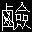

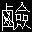

In [3]:
_, _, b = xmlToBitmap("./Genes/9E7C.02L.gene")
i = np.frombuffer(b, dtype=bool)
i = i.reshape(32, 32)
Image.fromarray(i)

In [4]:
def dupeCheckNew(han_char, new_X, new_y, out_dir="./HanBitmap"):
    """
    Checks new data for duplicates and removes them while appending the new data to an existing file
    """
    files = os.listdir(out_dir)
    if f"{out_dir}/{han_char}_X" not in files:
        fX = open(f"{out_dir}/{han_char}_X", "wb")
        fX.write(new_X)
        fy = open(f"{out_dir}/{han_char}_y", "w")
        fy.write(new_y)
        fX.close()
        fy.close()
        return
    han_char = f.split("_")[0]
    # check for duplicates
    fX = open(f"{out_dir}/{han_char}_X", "rb")
    fX_old = fX.readlines()
    fX_new = np.concatenate((np.array(fX_old), np.array(new_X.split())))
    uniques, u_filter = np.unique(fX_data, return_index=True, axis=0)
    if len(fX_data) == len(uniques):
        fX = open(f"{out_dir}/{han_char}_X", "ab")
        fX.write(new_X)
        fY = open(f"{out_dir}/{han_char}_y", "a")
        fy.write(new_y)
    elif len(fX_old) == len(uniques):
        pass
    else:
        fX_new = fX_new[u_filter]
        fX_str = b""
        for s in fX_new:
            fX_str += s
        fX.close()
        print(fX_str)
        fX = open(f"{out_dir}/{han_char}_X", "wb")
        fX.write(fX_str)
        fX.close()
        # only open fy if we made changes to fX
        fy = open(f"{out_dir}/{han_char}_y", "r")
        fy_new = np.concatenate((np.array(fy.readlines()), np.array(new_y.split())))[u_filter]
        fy_str = ""
        for s in fy_new:
            fy_str += s
        print(fy_str)
        fy = open(f"{out_dir}/{han_char}_y", "w")
        fy.write(fy_str)
    fX.close()
    fy.close()

def scanDir(xdir, out_dir="./HanBitmap"):
    """
    Iterates over a directory and scans all of the gene files within, outputting them in the form of bitmap (X) and score (y)
    """
    dir_list = os.listdir(xdir)
    files_X = {}
    files_y = {}
    for f in dir_list:
        if f.endswith(".gene"):
            han_char, score, bitmap = xmlToBitmap(f"{xdir}/{f}")
            if han_char not in files_X or han_char not in files_y:
                files_X[han_char] = b""
                files_y[han_char] = ""
            files_X[han_char] += bitmap + b"\n"
            files_y[han_char] += str(score) + "\n"
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    for han_char in files_X:
        fX = f"{out_dir}/{han_char}_X"
        fy = f"{out_dir}/{han_char}_y"
        dupeCheckNew(han_char, files_X[han_char], files_y[han_char], out_dir)

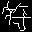

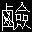

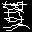

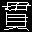

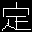

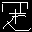

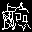

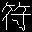

In [5]:
scanDir("Genes")